## Context
This is image data of Natural Scenes around the world.

## Content
This Data contains around 25k images of size 150x150 distributed under 6 categories.<br>
{'buildings' -> 0,<br>
'forest' -> 1,<br>
'glacier' -> 2,<br>
'mountain' -> 3,<br>
'sea' -> 4,<br>
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

### Import necessary Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os 
import torch 
import torchvision
import matplotlib.pyplot as plt 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision.transforms import ToTensor 
import torchvision.transforms as tt 
from torchvision.utils import make_grid 
from torch.utils.data.dataloader import DataLoader 
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split 
%matplotlib inline 

In [2]:
print(torch.__version__)

print(torchvision.__version__)

print(torch.version.cuda)

2.3.1+cu121
0.18.1+cu121
12.1


In [3]:
train = ImageFolder("/config/workspace/Data/seg_train",transform=tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))

In [4]:
train.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [5]:
train_dl = DataLoader(train,64,shuffle=True,num_workers=3,pin_memory=True)

In [6]:
def get_mean_std(dl):
    sum_,sqaured_sum,batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data,dim=([0,2,3]))
        sqaured_sum += torch.mean(data**2,dim=([0,2,3]))
        batches += 1

    mean = sum_/batches
    std = (sqaured_sum/batches - mean**2)**0.5
    return mean,std 

mean,std = get_mean_std(train_dl)
mean,std 

(tensor([0.4303, 0.4575, 0.4539]), tensor([0.2481, 0.2467, 0.2806]))

In [7]:
stats = ((0.4303, 0.4575, 0.4539),(0.2481, 0.2467, 0.2806))
train_transfrom = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transfrom = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [8]:
train = ImageFolder("/config/workspace/Data/seg_train/",transform=train_transfrom)
test = ImageFolder("/config/workspace/Data/seg_test/",transform=test_transfrom)

In [9]:
random_seed = 42
torch.manual_seed(random_seed)

In [10]:
val_size = int(len(train)*0.2)
train_size = len(train) - val_size 

train_ds , val_ds = random_split(train,[train_size,val_size])
len(train_ds),len(val_ds)

(11228, 2806)

In [11]:
batch_size = 128 

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_dl = DataLoader(val_ds,batch_size*2,num_workers=2,pin_memory=True)
test_dl = DataLoader(test,batch_size*2,num_workers=2,pin_memory=True)

In [12]:
def denormalize(iamges,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return iamges * stds + means 

def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images = denormalize(images,*stats)
        ax.imshow(make_grid(denorm_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break 

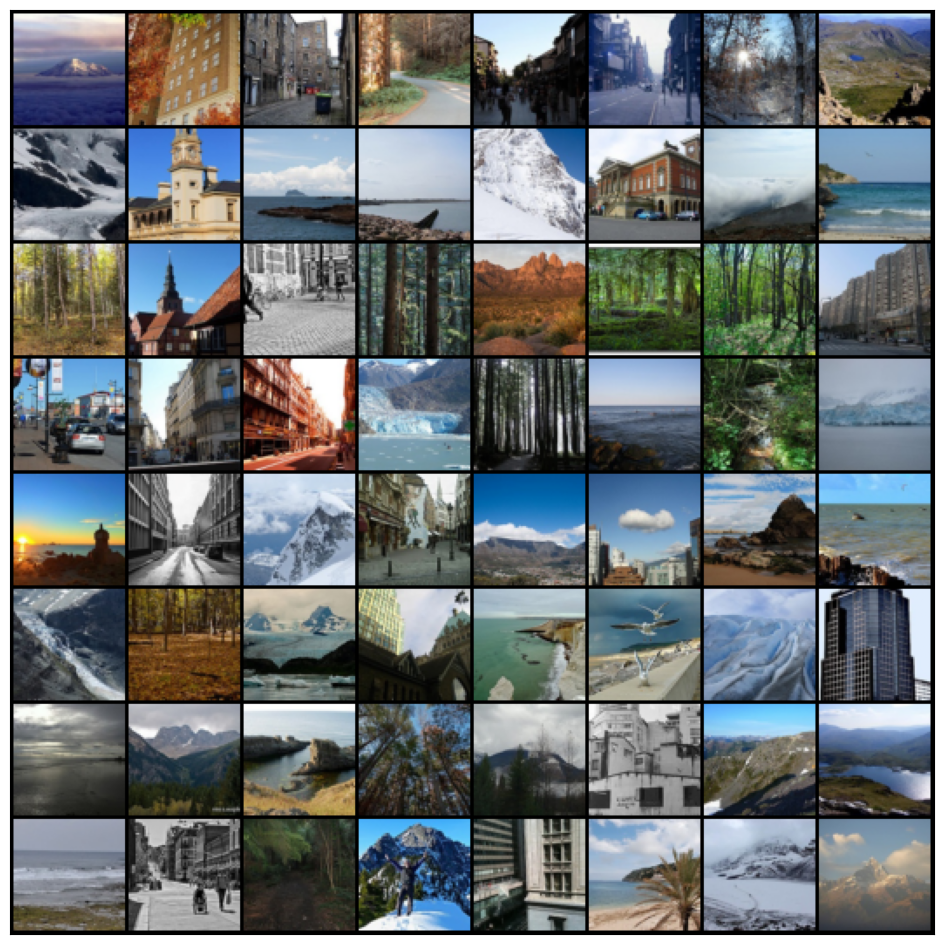

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """ Pick GPU if available , else CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    """ Move tensor(s) to chosen device """
    if isinstance(data,(list,tuple)):
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to device """ 
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device 

    def __iter__(self):
        """ yield a batch of data after moving it to device """
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """ Number of Batches """ 
        return len(self.dl)

In [15]:
get_default_device()

device(type='cpu')

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,lables = batch
        out = self(images)
        loss = F.cross_entropy(out,lables)
        return loss

    def validation_step(self,batch):
        images,lables = batch
        out = self(images)
        loss = F.cross_entropy(out,lables)
        acc = accuaracy(out,lables)
        return {'val_loss':loss.detach(),'val_acc':acc}

    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss']for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc']for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr:{:.5f},train_loss:{:.4f},val_loss:{:.4f},val_acc:{:.4f}".format(
            epoch,result['lrs'][-1],result['train_loss'],result['val_loss'],result['val_acc']))

def accuaracy(outputs,lables):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==lables).item()/len(preds))

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)
test_dl = DeviceDataLoader(test_dl,device)

## Building the Model

In [19]:
def conv_block(in_channels,out_channels,pool=False):
    layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self,in_channels,num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels,64)
        self.conv2 = conv_block(64,128,pool=True)
        self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

        self.conv3 = conv_block(128,256,pool=True)
        self.conv4 = conv_block(256,512,pool=True)
        self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out 
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.classifier(out)
        return out

In [20]:
no_of_classes = len(train.classes)
no_of_classes

6

In [21]:
model = to_device(ResNet9(3,no_of_classes),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Train the Model

In [22]:
@torch.no_grad()
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                  weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,
    steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = [] 
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            
            # Record & Update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation Phase
        result = evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [23]:
epochs = 12
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [24]:
history = []
%time 
history += fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,
           grad_clip=grad_clip,weight_decay=weight_decay,opt_func=opt_func) 

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.2 µs


: 

: 

In [ ]:
def plot_accuarcies(history):
    accuaracies = [x['val_acc'] for x in history]
    plt.plot(accuaracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuaracy')
    plt.title('Accuracy vs No. of Epochs')   

In [ ]:
plot_accuarcies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses,'-bx') 
    plt.plot(val_losses,'-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training','Validation'])
    plt.title('Loss vs No. of Epochs')    

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch No.')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch No.')                   

In [ ]:
plot_lrs(history)